In [10]:
#######################################################################################
# unet_conv_cifar10rgb_mc.py
# Convlutional Layer UNET with RGB Cifar10 dataset and Class with Keras Model approach
#######################################################################################

###########################
# AE 모델링
###########################
from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, \
    UpSampling2D, BatchNormalization, Concatenate, Activation


class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1

        def conv(x, n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        # Input
        original = Input(shape=org_shape)

        # Encoding
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        # Encoder
        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid',
                         padding='same')(x)

        super().__init__(original, decoded)
        self.compile(optimizer='adadelta', loss='binary_crossentropy')


###########################
# 데이타 불러오기
###########################
from keras import datasets, utils


class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        if x_train.ndim == 4:
            img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
        # in_ch can be 1 for changing BW to color image using UNet
        in_ch = n_ch if in_ch is None else in_ch

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:  # "channels_last
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B

        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch


###########################
# UNET 검증
###########################
from ann_mnist_cl import plot_loss
import matplotlib.pyplot as plt


###########################
# UNET 동작 확인
###########################
def show_images(data, autoencoder):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = autoencoder.predict(x_test_in)

    if backend.image_data_format() == 'channels_first':
        x_test_in = x_test_in[:, 0, ...]
        x_test_out = x_test_out.swapaxes(1, 3)
        decoded_imgs = decoded_imgs.swapaxes(1, 3)
    else:
        x_test_in = x_test_in[..., 0]

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_in[i], cmap='gray')
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def main(epochs=100, batch_size=128, fig=True):
    ###########################
    # 학습 및 확인
    ###########################

    # BW to Color
    data = DATA(in_ch=1)
    unet = UNET(data.input_shape, data.n_ch)

    history = unet.fit(data.x_train_in, data.x_train_out,
                       epochs=epochs,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_split=0.2)

    if fig:
        plot_loss(history)
        show_images(data, unet)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 25s - loss: 0.5873 - val_loss: 0.6295
Epoch 2/20
40000/40000 [==============================] - 18s - loss: 0.5708 - val_loss: 0.6009
Epoch 3/20
40000/40000 [==============================] - 18s - loss: 0.5679 - val_loss: 0.5669
Epoch 4/20
40000/40000 [==============================] - 18s - loss: 0.5665 - val_loss: 0.5678
Epoch 5/20
40000/40000 [==============================] - 18s - loss: 0.5656 - val_loss: 0.5651
Epoch 6/20
40000/40000 [==============================] - 18s - loss: 0.5650 - val_loss: 0.5672
Epoch 7/20
40000/40000 [==============================] - 18s - loss: 0.5646 - val_loss: 0.5677
Epoch 8/20
40000/40000 [==============================] - 18s - loss: 0.5642 - val_loss: 0.5674
Epoch 9/20
40000/40000 [==============================] - 18s - loss: 0.5639 - val_loss: 0.5639
Epoch 10/20
40000/40000 [==============================] - 18s - loss: 0.5637 - val_lo

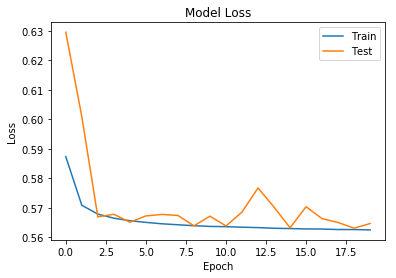

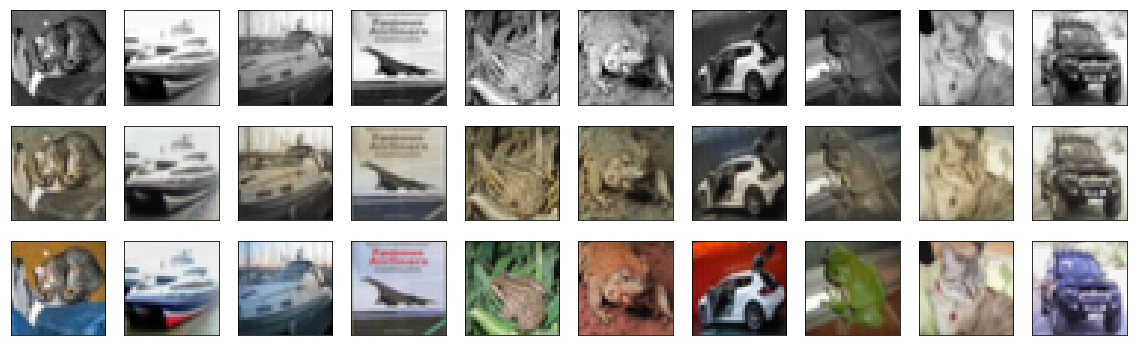

In [12]:
main(epochs=20)

In [6]:
if __name__ == '__main__':
    import argparse
    from distutils import util

    parser = argparse.ArgumentParser(description='UNET for Cifar-10: BW to Color')
    parser.add_argument('--epochs', type=int, default=128,
                        help='training epochs (default: 128)')
    parser.add_argument('--batch_size', type=int, default=20,
                        help='batch size (default: 20)')
    parser.add_argument('--fig', type=lambda x: bool(util.strtobool(x)),
                        default=True, help='flag to show figures (default: True)')
    args = parser.parse_args()

    print("Aargs:", args)
    main(args.epochs, args.batch_size, args.fig)

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--fig FIG]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-1c189a24-13c7-40fa-8dd9-2615bd2148aa.json


SystemExit: 2

/home/sjkim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
